# Classification

As we decided to analyse, whether the flight is delayed (situation, where the flight arrived after the scheduled time, Flight status = 1) or not (arrive time was before the scheduled time or on it) we will use classification model to predict delay possibility.

## Libraries import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from google.colab import files
import io

#from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score, cross_val_predict
from sklearn import metrics, linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

## Dataset loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
flights = pd.read_csv('/content/drive/MyDrive/DataScience/flights_prep2.csv', low_memory=True)
# tutaj chyba powinien być plik flights_prep2.csv -> on jest generowany po zamianie ARRIVAL_DELAY z minut spóźnienia na FLIGHT STATUS


In [ ]:
flights.head()

,Unnamed: 0,MONTH,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,FLIGHT_STATUS
0,0,1,4,Alaska Airlines,98,N407AS,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,00:05:00,-11.0,169.0,1448,04:30:00,0.0,0.0,0.0,0.0,0.0,2015-01-01,0
1,1,1,4,American Airlines,2336,N3KUAA,Los Angeles International Airport,Palm Beach International Airport,00:10:00,-8.0,263.0,2330,07:50:00,0.0,0.0,0.0,0.0,0.0,2015-01-01,0
2,2,1,4,American Airlines,840,N171US,San Francisco International Airport,Charlotte Douglas International Airport,00:20:00,-2.0,266.0,2296,08:06:00,0.0,0.0,0.0,0.0,0.0,2015-01-01,1
3,3,1,4,American Airlines,258,N3HYAA,Los Angeles International Airport,Miami International Airport,00:20:00,-5.0,258.0,2342,08:05:00,0.0,0.0,0.0,0.0,0.0,2015-01-01,0
4,4,1,4,Alaska Airlines,135,N527AS,Seattle-Tacoma International Airport,Ted Stevens Anchorage International Airport,00:25:00,-1.0,199.0,1448,03:20:00,0.0,0.0,0.0,0.0,0.0,2015-01-01,0


In [ ]:
# flights.nlargest(10, ['DEPARTURE_DELAY'])

## Pearson correlation Matrix of Variables

Following exploratory analysis data from April and December will be used for further modeling. 

In [ ]:
flights = flights[(flights['MONTH'] == 4) | (flights['MONTH'] == 12)]
flights.sample(10)

,Unnamed: 0,MONTH,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,FLIGHT_STATUS
1783462,1783462,4,1,Southwest Airlines,719,N394SW,Greater Rochester International Airport,Baltimore-Washington International Airport,18:40:00,-4.0,49.0,277,19:50:00,0.0,0.0,0.0,0.0,0.0,2015-04-27,0
5035017,5035017,12,5,Southwest Airlines,1987,N484WN,Denver International Airport,Louisville International Airport (Standiford F...,18:20:00,29.0,112.0,1024,22:45:00,0.0,0.0,0.0,0.0,0.0,2015-12-18,1
1419756,1419756,4,6,Southwest Airlines,2357,N658SW,Hartsfield-Jackson Atlanta International Airport,Port Columbus International Airport,20:50:00,6.0,69.0,447,22:30:00,0.0,0.0,0.0,0.0,0.0,2015-04-04,0
1688421,1688421,4,2,Delta Airlines,1722,N3758Y,Louis Armstrong New Orleans International Airport,Los Angeles International Airport,19:04:00,-7.0,227.0,1670,21:30:00,0.0,0.0,0.0,0.0,0.0,2015-04-21,0
4789413,4789413,12,3,Southwest Airlines,3214,N288WN,Kansas City International Airport,Dallas Love Field,18:00:00,48.0,76.0,460,19:30:00,1.0,0.0,2.0,46.0,0.0,2015-12-02,1
5041103,5041103,12,6,Delta Airlines,2124,N374NW,Louis Armstrong New Orleans International Airport,Hartsfield-Jackson Atlanta International Airport,07:50:00,0.0,58.0,425,10:12:00,0.0,0.0,0.0,0.0,0.0,2015-12-19,0
1542247,1542247,4,7,Envoy Air,3008,N544MQ,Chicago O'Hare International Airport,Nashville International Airport,16:55:00,163.0,57.0,409,18:33:00,0.0,0.0,142.0,0.0,0.0,2015-04-12,1
5213148,5213148,12,3,JetBlue Airways,341,N197JB,Henry E. Rohlsen Airport,Luis Muñoz Marín International Airport,16:46:00,-3.0,23.0,94,17:28:00,0.0,0.0,0.0,0.0,0.0,2015-12-30,0
1472864,1472864,4,3,SkyWest Airlines,4576,N913EV,Minneapolis-Saint Paul International Airport,Rapid City Regional Airport,09:00:00,271.0,83.0,489,09:49:00,0.0,0.0,246.0,23.0,0.0,2015-04-08,1
1791958,1791958,4,2,Envoy Air,3017,N1EAMQ,Chicago O'Hare International Airport,The Eastern Iowa Airport,10:40:00,-2.0,31.0,196,11:45:00,0.0,0.0,0.0,0.0,0.0,2015-04-28,0


Removing of columns that will be not analysed

In [ ]:
columns_to_drop = ['Unnamed: 0', 'MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DATE']
flights.drop(columns_to_drop, axis = 1, inplace = True)
flights.head()

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,AIR_TIME,DISTANCE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLIGHT_STATUS
1356814,3,Alaska Airlines,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,1.0,183.0,1448,0.0,0.0,0.0,0.0,0.0,0
1356815,3,American Airlines,Salt Lake City International Airport,Charlotte Douglas International Airport,-5.0,205.0,1727,0.0,0.0,0.0,0.0,0.0,0
1356816,3,American Airlines,Los Angeles International Airport,Philadelphia International Airport,-10.0,272.0,2402,0.0,0.0,0.0,0.0,0.0,0
1356817,3,American Airlines,Seattle-Tacoma International Airport,Dallas/Fort Worth International Airport,-3.0,211.0,1660,0.0,0.0,0.0,0.0,0.0,0
1356818,3,Delta Airlines,San Francisco International Airport,Minneapolis-Saint Paul International Airport,-3.0,171.0,1589,0.0,0.0,0.0,0.0,0.0,0


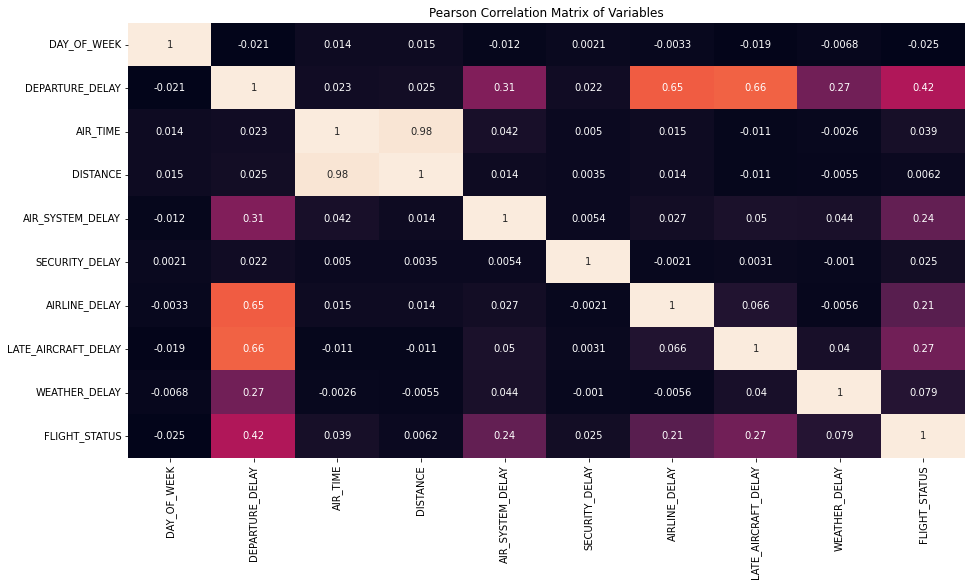

In [ ]:
# plot the correlation matrix
corr_matrix = flights.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True, cbar=False)
plt.title("Pearson Correlation Matrix of Variables")
plt.show()



Summary:
- AIR_TIME and DISTANCE are highly correlated; only one variable of them can be used for modeling
- FLIGHT_STATUS (delayed = 1 or not = 0) is highly related with variables: DEPARTURE_DELAY, AIR_SYSTEM_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY

In [ ]:
flights.drop('AIR_TIME', axis=1, inplace=True)
flights.head()

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLIGHT_STATUS
1356814,3,Alaska Airlines,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,1.0,1448,0.0,0.0,0.0,0.0,0.0,0
1356815,3,American Airlines,Salt Lake City International Airport,Charlotte Douglas International Airport,-5.0,1727,0.0,0.0,0.0,0.0,0.0,0
1356816,3,American Airlines,Los Angeles International Airport,Philadelphia International Airport,-10.0,2402,0.0,0.0,0.0,0.0,0.0,0
1356817,3,American Airlines,Seattle-Tacoma International Airport,Dallas/Fort Worth International Airport,-3.0,1660,0.0,0.0,0.0,0.0,0.0,0
1356818,3,Delta Airlines,San Francisco International Airport,Minneapolis-Saint Paul International Airport,-3.0,1589,0.0,0.0,0.0,0.0,0.0,0


Analysis of Airports busy

In [ ]:
flights.ORIGIN_AIRPORT.value_counts()

Hartsfield-Jackson Atlanta International Airport    61870
Chicago O'Hare International Airport                49835
Dallas/Fort Worth International Airport             41438
Denver International Airport                        34856
Los Angeles International Airport                   34069
                                                    ...  
Bangor International Airport                           24
Pago Pago International Airport (Tafuna Airport)       17
Mammoth Yosemite Airport                               17
Adak Airport                                           15
Del Norte County Airport (Jack McNamara Field)         12
Name: ORIGIN_AIRPORT, Length: 314, dtype: int64

In [ ]:
flights.DESTINATION_AIRPORT.value_counts()

Hartsfield-Jackson Atlanta International Airport    61799
Chicago O'Hare International Airport                49774
Dallas/Fort Worth International Airport             41080
Denver International Airport                        34811
Los Angeles International Airport                   34070
                                                    ...  
Bangor International Airport                           24
Pago Pago International Airport (Tafuna Airport)       18
Mammoth Yosemite Airport                               17
Adak Airport                                           15
Del Norte County Airport (Jack McNamara Field)         11
Name: DESTINATION_AIRPORT, Length: 314, dtype: int64

In [ ]:
flights.DESTINATION_AIRPORT.value_counts().iloc[:15]

Hartsfield-Jackson Atlanta International Airport    61799
Chicago O'Hare International Airport                49774
Dallas/Fort Worth International Airport             41080
Denver International Airport                        34811
Los Angeles International Airport                   34070
Phoenix Sky Harbor International Airport            26823
San Francisco International Airport                 26290
George Bush Intercontinental Airport                25398
McCarran International Airport                      24050
Orlando International Airport                       21140
Minneapolis-Saint Paul International Airport        19652
Seattle-Tacoma International Airport                19492
Detroit Metropolitan Airport                        19454
Gen. Edward Lawrence Logan International Airport    18943
Newark Liberty International Airport                18624
Name: DESTINATION_AIRPORT, dtype: int64

In [ ]:
top_airports = flights.DESTINATION_AIRPORT.value_counts().iloc[0:15].rename_axis('DESTINATION_AIRPORT').reset_index(name='TOTAL_FLIGHTS')
top_airports

,DESTINATION_AIRPORT,TOTAL_FLIGHTS
0,Hartsfield-Jackson Atlanta International Airport,61799
1,Chicago O'Hare International Airport,49774
2,Dallas/Fort Worth International Airport,41080
3,Denver International Airport,34811
4,Los Angeles International Airport,34070
5,Phoenix Sky Harbor International Airport,26823
6,San Francisco International Airport,26290
7,George Bush Intercontinental Airport,25398
8,McCarran International Airport,24050
9,Orlando International Airport,21140


In [ ]:
airport_list = top_airports['DESTINATION_AIRPORT'].tolist()
airport_list

['Hartsfield-Jackson Atlanta International Airport',
 "Chicago O'Hare International Airport",
 'Dallas/Fort Worth International Airport',
 'Denver International Airport',
 'Los Angeles International Airport',
 'Phoenix Sky Harbor International Airport',
 'San Francisco International Airport',
 'George Bush Intercontinental Airport',
 'McCarran International Airport',
 'Orlando International Airport',
 'Minneapolis-Saint Paul International Airport',
 'Seattle-Tacoma International Airport',
 'Detroit Metropolitan Airport',
 'Gen. Edward Lawrence Logan International Airport',
 'Newark Liberty International Airport']

In [ ]:
boolean_series =  flights.DESTINATION_AIRPORT.isin(airport_list)
boolean_series

1356814     True
1356815    False
1356816    False
1356817     True
1356818     True
           ...  
5231125     True
5231126    False
5231127    False
5231128    False
5231129    False
Name: DESTINATION_AIRPORT, Length: 948968, dtype: bool

In [ ]:
flights = flights[boolean_series]

In [ ]:
boolean_series =  flights.ORIGIN_AIRPORT.isin(airport_list)
boolean_series

1356814    False
1356817     True
1356818     True
1356819     True
1356820     True
           ...  
5231116    False
5231117     True
5231119     True
5231122    False
5231125     True
Name: ORIGIN_AIRPORT, Length: 441400, dtype: bool

In [ ]:
flights = flights[boolean_series]

In [ ]:
flights.DESTINATION_AIRPORT.value_counts()

Los Angeles International Airport                   15332
Chicago O'Hare International Airport                13602
San Francisco International Airport                 12608
Hartsfield-Jackson Atlanta International Airport    12399
Denver International Airport                        12152
Dallas/Fort Worth International Airport             10753
McCarran International Airport                      10623
Phoenix Sky Harbor International Airport            10531
Seattle-Tacoma International Airport                 9105
George Bush Intercontinental Airport                 7958
Newark Liberty International Airport                 7851
Minneapolis-Saint Paul International Airport         7679
Orlando International Airport                        7590
Gen. Edward Lawrence Logan International Airport     7394
Detroit Metropolitan Airport                         6748
Name: DESTINATION_AIRPORT, dtype: int64

In [ ]:
flights.ORIGIN_AIRPORT.value_counts()

Los Angeles International Airport                   15251
Chicago O'Hare International Airport                13558
San Francisco International Airport                 12651
Hartsfield-Jackson Atlanta International Airport    12404
Denver International Airport                        12252
Dallas/Fort Worth International Airport             10850
McCarran International Airport                      10586
Phoenix Sky Harbor International Airport            10544
Seattle-Tacoma International Airport                 9066
George Bush Intercontinental Airport                 7916
Newark Liberty International Airport                 7892
Minneapolis-Saint Paul International Airport         7721
Orlando International Airport                        7567
Gen. Edward Lawrence Logan International Airport     7340
Detroit Metropolitan Airport                         6727
Name: ORIGIN_AIRPORT, dtype: int64

In [ ]:
flights.head()

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLIGHT_STATUS
1356817,3,American Airlines,Seattle-Tacoma International Airport,Dallas/Fort Worth International Airport,-3.0,1660,0.0,0.0,0.0,0.0,0.0,0
1356818,3,Delta Airlines,San Francisco International Airport,Minneapolis-Saint Paul International Airport,-3.0,1589,0.0,0.0,0.0,0.0,0.0,0
1356819,3,Delta Airlines,Denver International Airport,Hartsfield-Jackson Atlanta International Airport,-8.0,1199,0.0,0.0,0.0,0.0,0.0,0
1356820,3,Spirit Airlines,Phoenix Sky Harbor International Airport,Chicago O'Hare International Airport,74.0,1440,1.0,0.0,1.0,69.0,0.0,1
1356822,3,United Airlines,San Francisco International Airport,Chicago O'Hare International Airport,-1.0,1846,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
#https://en.wikipedia.org/wiki/Flight_cancellation_and_delay ponizej 15min to nie opoznienie wedlug wikipedii :D

## Variables encoding to dumnies

In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152325 entries, 1356817 to 5231125
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   DAY_OF_WEEK          152325 non-null  int64  
 1   AIRLINE              152325 non-null  object 
 2   ORIGIN_AIRPORT       152325 non-null  object 
 3   DESTINATION_AIRPORT  152325 non-null  object 
 4   DEPARTURE_DELAY      152325 non-null  float64
 5   DISTANCE             152325 non-null  int64  
 6   AIR_SYSTEM_DELAY     152325 non-null  float64
 7   SECURITY_DELAY       152325 non-null  float64
 8   AIRLINE_DELAY        152325 non-null  float64
 9   LATE_AIRCRAFT_DELAY  152325 non-null  float64
 10  WEATHER_DELAY        152325 non-null  float64
 11  FLIGHT_STATUS        152325 non-null  int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 15.1+ MB


In [ ]:
#Encoding

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)


In [ ]:
features_to_encode = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT']
flights = encode_and_bind(flights, features_to_encode[0])
flights = encode_and_bind(flights, features_to_encode[1])
flights = encode_and_bind(flights, features_to_encode[2])


In [ ]:
# change FLIGHT_STATUS to 'category'
flights["FLIGHT_STATUS"] = flights["FLIGHT_STATUS"].astype('category')

In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152325 entries, 1356817 to 5231125
Data columns (total 51 columns):
 #   Column                                                                Non-Null Count   Dtype   
---  ------                                                                --------------   -----   
 0   DAY_OF_WEEK                                                           152325 non-null  int64   
 1   DEPARTURE_DELAY                                                       152325 non-null  float64 
 2   DISTANCE                                                              152325 non-null  int64   
 3   AIR_SYSTEM_DELAY                                                      152325 non-null  float64 
 4   SECURITY_DELAY                                                        152325 non-null  float64 
 5   AIRLINE_DELAY                                                         152325 non-null  float64 
 6   LATE_AIRCRAFT_DELAY                                                  

In [ ]:
# Save of the dataset fo csv

flights.to_csv('/content/drive/MyDrive/DataScience/flights_data_new.csv',index=False)


## Choosing of dependent and undependent variables

In [ ]:
y = flights['FLIGHT_STATUS'].copy()
X = flights.drop('FLIGHT_STATUS', axis=1).copy()

## split data to train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7, random_state=12)

# Decission Tree

Test Accuracy: 80.37%


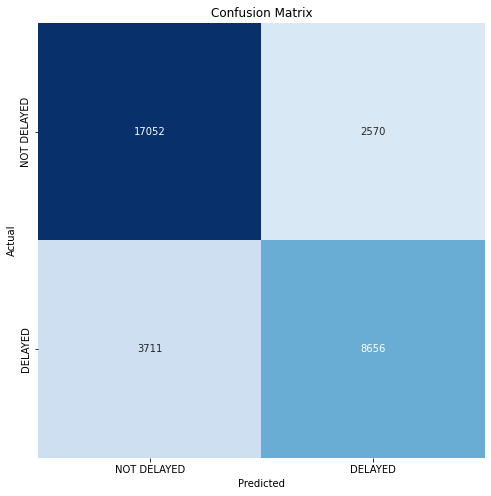

Classification Report:
----------------------
               precision    recall  f1-score   support

 NOT DELAYED       0.82      0.87      0.84     19622
     DELAYED       0.77      0.70      0.73     12367

    accuracy                           0.80     31989
   macro avg       0.80      0.78      0.79     31989
weighted avg       0.80      0.80      0.80     31989



In [ ]:
model = DecisionTreeClassifier(max_depth=100)
model.fit(X_train, y_train)
model_acc = model.score(X_valid, y_valid)
print("Test Accuracy: {:.2f}%".format(model_acc * 100))

y_true = np.array(y_valid)
y_pred = model.predict(X_valid)

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["NOT DELAYED", "DELAYED"])

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.yticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
fig = plt.figure(figsize=(15,20))
_ = tree.plot_tree(model, feature_names=flights.columns, filled=True)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff3c8f39280> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7ff3c8c58e50> (for post_execute):


KeyboardInterrupt: ignored

Text(0.5, 0, 'max depth')

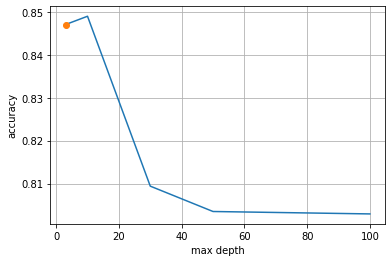

In [ ]:
from sklearn.metrics import accuracy_score
max_depth_list = [3,10,30,50,100]

accuracy = []

for x in max_depth_list:
    dtc = DecisionTreeClassifier(max_depth=x) 
    dtc.fit(X_train, y_train)
    accuracy.append(dtc.score(X_valid, y_valid))

plt.plot(max_depth_list, accuracy) 
plt.plot(max_depth_list[0], accuracy[0], marker='o') 
plt.grid() #adds a grid to the plot
plt.ylabel('accuracy') #xlabel
plt.xlabel('max depth') #ylabel

In [ ]:
DT_regr = DecisionTreeClassifier(max_depth=10, random_state=369)
DT_model = DT_regr.fit(X_train,y_train)
DT_predictions = pd.DataFrame(DT_regr.predict(X_test))
print("MSE =", metrics.mean_squared_error(DT_predictions, y_test))
DT_accuracy = DT_model.score(X_test, y_test)
print('DT Accuracy on Test Set = '+ str(DT_accuracy.round(2)))

MSE = 0.15442688957941267
DT Accuracy on Test Set = 0.85


## Random forest

# to zostało na razie przeniesione

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=100, max_depth=10)
random_forest_classifier = random_forest_model.fit(X_train,y_train)

In [ ]:
y_pred_randomforest = random_forest_model.predict(X_test)
print("Random Forest Clasifier Train Accuracy : {} %".format(random_forest_classifier.score(X_train,
                                                                                            y_train)*100))
print("Random Forest Clasifier Test Accuracy : {} %".format(random_forest_classifier.score(X_valid,
                                                                                            y_valid)*100))


In [ ]:
y_true = np.array(y_valid)
y_pred = random_forest_model.predict(X_valid)

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["NOT DELAYED", "DELAYED"])

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.yticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)